In [7]:
import numpy as np
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    delta = norm.cdf(d1)
    return call_price, delta

def binomial_model(S, K, T, r, sigma, N=100, option_type='call'):
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    asset_prices = np.zeros(N + 1)
    option_values = np.zeros(N + 1)

    for i in range(N + 1):
        asset_prices[i] = S * (u ** (N - i)) * (d ** i)

    if option_type == 'call':
        option_values = np.maximum(asset_prices - K, 0)
    elif option_type == 'put':
        option_values = np.maximum(K - asset_prices, 0)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            option_values[i] = (p * option_values[i] + (1 - p) * option_values[i + 1]) * np.exp(-r * dt)

    delta = (option_values[0] - option_values[1]) / (asset_prices[0] - asset_prices[1])

    return option_values[0], delta

# Hedged position function
def hedged_position(option_price, delta, S_initial, S_final, K):
    call_payoff = max(S_final - K, 0)
    shares_gain = delta * (S_final - S_initial)
    net_result = option_price + shares_gain - call_payoff
    return net_result

# Parameters
S0 = 1333.30
K = 1340
T = 0.03836
r = 0.06
sigma = 0.30
N = 100
S_final = 1349.85

bs_price, bs_delta = black_scholes_call(S0, K, T, r, sigma)
binomial_price, binomial_delta = binomial_model(S0, K, T, r, sigma, N, option_type='call')

bs_hedge = hedged_position(bs_price, bs_delta, S0, S_final, K)
bin_hedge = hedged_position(binomial_price, binomial_delta, S0, S_final, K)

print(f"Black-Scholes Call Price: ₹{bs_price:.2f}")
print(f"Black-Scholes Delta: {bs_delta:.4f}")
print(f"Binomial Model Call Price: ₹{binomial_price:.2f}")
print(f"Binomial Model Delta: {binomial_delta:.4f}")
print(f"Black-Scholes Hedged Position at Expiry: ₹{bs_hedge:.2f}")
print(f"Binomial Model Hedged Position at Expiry: ₹{bin_hedge:.2f}")


Black-Scholes Call Price: ₹29.51
Black-Scholes Delta: 0.4933
Binomial Model Call Price: ₹29.59
Binomial Model Delta: 0.1380
Black-Scholes Hedged Position at Expiry: ₹27.83
Binomial Model Hedged Position at Expiry: ₹22.02


In [8]:
def delta_sensitivity(model_func, S, K, T, r, sigma, N=100):
    dS = 1.0
    price_up, delta_up = model_func(S + dS, K, T, r, sigma, N)
    price_down, delta_down = model_func(S - dS, K, T, r, sigma, N)
    approx_delta = (price_up - price_down) / (2 * dS)
    return approx_delta

def bs_wrapper(S, K, T, r, sigma, N=0):
    price, delta = black_scholes_call(S, K, T, r, sigma)
    return price, delta

bs_delta_sens = delta_sensitivity(bs_wrapper, S0, K, T, r, sigma)
bin_delta_sens = delta_sensitivity(binomial_model, S0, K, T, r, sigma, N)

print(f"Black-Scholes Approximate Delta: {bs_delta_sens:.4f}")
print(f"Binomial Model Approximate Delta: {bin_delta_sens:.4f}")


Black-Scholes Approximate Delta: 0.4933
Binomial Model Approximate Delta: 0.4876


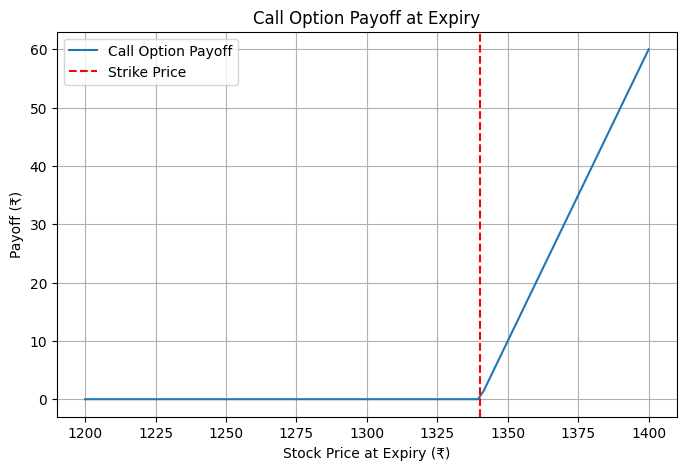

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Payoff diagram for a call option
S_range = np.linspace(1200, 1400, 100)
call_payoff = np.maximum(S_range - K, 0)

plt.figure(figsize=(8,5))
plt.plot(S_range, call_payoff, label='Call Option Payoff')
plt.axvline(K, color='r', linestyle='--', label='Strike Price')
plt.title('Call Option Payoff at Expiry')
plt.xlabel('Stock Price at Expiry (₹)')
plt.ylabel('Payoff (₹)')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
steps = [1, 5, 10, 25, 50, 100, 200, 500]
bin_prices = []

for n in steps:
    price, _ = binomial_model(S0, K, T, r, sigma, N=n)
    bin_prices.append(price)

bs_price, _ = black_scholes_call(S0, K, T, r, sigma)

print("Steps | Binomial Price | Black-Scholes Price")
for i, n in enumerate(steps):
    print(f"{n:5d} | {bin_prices[i]:14.4f} | {bs_price:18.4f}")


Steps | Binomial Price | Black-Scholes Price
    1 |        37.2716 |            29.5150
    5 |        30.9850 |            29.5150
   10 |        29.4543 |            29.5150
   25 |        29.7136 |            29.5150
   50 |        29.6208 |            29.5150
  100 |        29.5893 |            29.5150
  200 |        29.5505 |            29.5150
  500 |        29.5048 |            29.5150
